In [1]:
using FFTW, Plots, LinearAlgebra, LaTeXStrings, SparseArrays, Printf, FiniteDifferences
include("./amath586.jl")
using .amath586
import Base: diff, *

# Caution!

$$ u'(t) = \alpha u(t) + u(t)(1-u(t)), \quad u(0) = \eta $$

In [2]:
c = 0.0; α = 1e-8
u = t -> (1 + α)*exp((1 + α)*t)/(exp((1 + α)*t) + exp(c))
F = U -> U*(1-U)

k = 0.00001
T = 1.0
U = u(0.0)
t = 0
m = convert(Int64,floor(T/k))
Us = zeros(m+1)
Us[1] = U
ks = zeros(m+1)
for i = 1:convert(Int64,floor(T/k))
    t += k
    U = exp(α*k)*U + ((exp(α*k)-1)/α)*F(U)
    Us[i+1] = U
    ks[i+1] = t
end
U - u(1.0)

-0.00015890616872415997

In [3]:
c = 0.0; α = 1e-8
u = t -> (1 + α)*exp((1 + α)*t)/(exp((1 + α)*t) + exp(c))
F = U -> α*U + U*(1-U)

k = 0.0001
T = 1.0
U = u(0.0)
t = 0
m = convert(Int64,floor(T/k))
Us = zeros(m+1)
Us[1] = U
ks = zeros(m+1)
for i = 1:convert(Int64,floor(T/k))
    t += k
    U += k*F(U)
    Us[i+1] = U
    ks[i+1] = t
end
U - u(1.0)

2.3615793313114253e-6

Suppose $f$ is an entire function with a removable singularity at the origin.  We need code to evaluate it reliably in the complex plan.  We suppose it is reliably evaluated for $|z| \geq 1/2$.  

In [4]:
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n

#19 (generic function with 1 method)

In [5]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end

function disk_eval(tr::trig_interp,x,r) # just sums the Laurent series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)*r
    sum = tr.c[mm+1]
    for i = mm+2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end

diffvec = (L,m,j) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^j

#21 (generic function with 1 method)

In [6]:
N₋ = m -> convert(Int64,floor(m/2))
N₊ = m -> convert(Int64,floor((m-1)/2))

#25 (generic function with 1 method)

In [41]:
function stable_eval(f,z,rad)
    n = 2^2
    cs = mfft(map(f,rad*exp.(1im*mgrid(n,pi))))
    while maximum(abs.(cs[1:4])) > 1e-14 || maximum(abs.(cs[end-3:end])) > 1e-14
        n = 4*n
        cs = mfft(map(f,rad*exp.(1im*mgrid(n,pi))))
        if n > 1e5
            print("Did not achieve tolerance")
            display(maximum(abs.(cs[1:4])) + maximum(abs.(cs[end-3:end])))
            break
        end
    end
    tr = trig_interp(pi,cs)
    map( z -> abs(z) > rad/2 ? f(z) : disk_eval(tr,angle(z),abs(z/rad)), z |> complex)
end

stable_eval (generic function with 2 methods)

In [42]:
stable_eval(z -> (exp(z)-1)/z, -2:.5:1, 2)

7-element Vector{ComplexF64}:
 0.43233235838169365 - 0.0im
  0.5179132265677134 - 0.0im
  0.6321205588285579 + 3.882162835762087e-17im
  0.7869386805747328 + 3.7012935237918826e-17im
                 1.0 + 2.111573639122173e-17im
  1.2974425414002562 + 2.472230643903204e-17im
  1.7182818284590455 + 2.5568156545890775e-17im

In [26]:
map(z -> (exp(z)-1)/z, -2:.5:1)

7-element Vector{Float64}:
   0.43233235838169365
   0.5179132265677134
   0.6321205588285577
   0.7869386805747332
 NaN
   1.2974425414002564
   1.718281828459045

## A nonlinear heat equation

Consider solving, with periodic boundary conditions,



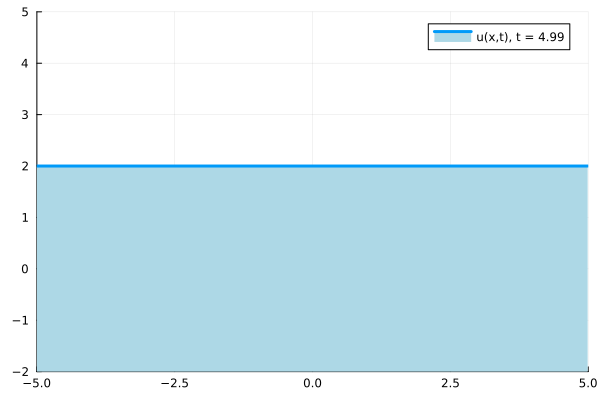

[ Info: Saved animation to /Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2023/notebooks/nonlinear_heat.gif


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2023/notebooks/nonlinear_heat.gif")
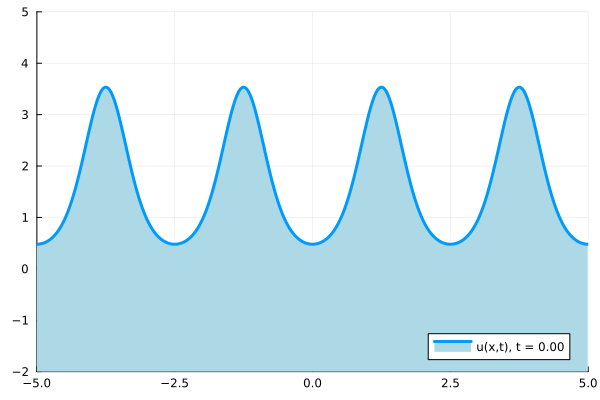

In [9]:
anim = Animation()
η = x -> 1.3*exp.(-cos.(4*pi*x/L))

L = 5.
N = 2^10
γ = 1.
X = mgrid(N,L)
c = mfft(η(X))
D2 = diffvec(L,N,2)
U = mifft(c)
cl = [-2,5]
k = 0.01
t = 0.0

N = u -> u.^2.0.*(1 .- u).*(u .- 2.0)

E0 = Diagonal(exp.(D2*k))
E1 = k*stable_eval(z -> (exp(z)-1)/z, D2*k) |> Diagonal

plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)

for i = 2:500
    t += k
    c = E0*c + E1*mfft(N(mifft(c)))
    IJulia.clear_output(true)        
    plot(X, mifft(c) |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
    frame(anim)
end
gif(anim,"nonlinear_heat.gif")

The fourth-order ETDRK4 scheme, as given by Cox and Matthews is
\begin{align*}
a = & e^{A k / 2} a^n +A^{-1}\left(e^{A k / 2}-I\right) \tilde{\mathcal N}\left(a^n\right) \\
b = & e^{A k / 2} a^n+A^{-1}\left(e^{A k / 2}-I\right) \tilde{\mathcal N}\left(a\right) \\
c = & e^{A k / 2} a+A^{-1}\left(e^{A k / 2}-I\right)\left(2 \tilde{\mathcal N}\left(b \right)-\tilde{\mathcal N}\left(a^n\right)\right) \\
a^{n+1}= & e^{A k} a^n+k^{-2} A^{-3}\left\{\left[-4-A k+e^{A k}\left(4-3 A k+(A k)^2\right)\right] \tilde{\mathcal N}\left(a^n\right)\right. \\
& +2\left[2+A k+e^{A k}(-2+A k)\right]\left(\tilde{\mathcal N}\left(a\right)+\tilde{\mathcal N}\left(b\right)\right) \\
& \left.+\left[-4-3 A k-(A k)^2+e^{A k}(4-A k)\right] \tilde{\mathcal N}\left(c\right)\right\}
\end{align*}
This scheme can be simplified by defining
\begin{align*}
    f_0(z) &= \frac{e^{z/2}-1}{z},\\
    f_1(z) &=  z^{-3} \left[-4 - z + e^z (4 - 3z + z^2),  \right],\\
    f_2(z) &= 2 z^{-3} \left[ 2 + z + e^z(-2 + z)\right],\\
    f_3(z) &= z^{-3} \left[-4 - 3 z - z^2 + e^z (4 - z)\right],\\
    S_{1/2} &= e^{Ak/2}, S_1 = e^{Ak}.
\end{align*}
Then
\begin{align*}
a &= S_{1/2} a^n + k f_0(Ak) \tilde{\mathcal N}\left(a^n\right),\\
b &= S_{1/2} a^n + k f_0(Ak) \tilde{\mathcal N}\left(a\right),\\
c & = S_{1/2} a + k f_0(Ak) ( 2 \tilde{\mathcal N}\left(b\right) - \tilde{\mathcal N}\left(a^n\right)),\\
a^{n+1} &= S_1 a^n + k f_1(Ak) \tilde{\mathcal N}\left(a^n\right) + k f_2(Ak) (\tilde{\mathcal N}\left(a\right) + \tilde{\mathcal N}\left(b\right) ) + k f_3(Ak) \tilde{\mathcal N}\left(c\right).
\end{align*}

In [13]:
f0 = z -> (exp(z/2)-1)/z
f1 = z -> (-4 - z + exp(z)*(4-3z+z^2))/z^3
f2 = z -> 2*(2 + z + exp(z)*(-2 + z))/z^3
f3 = z -> (-4 - 3z - z^2 + exp(z)*(4-z))/z^3

#53 (generic function with 1 method)

In [35]:
stable_eval(f3, .3, 2) |> display
f3(.3)

0.16583659374857354 - 3.601331427544009e-18im

0.16583659374858473

In [ ]:
f0()

In [ ]:
stable_eval(f0, D2*k)

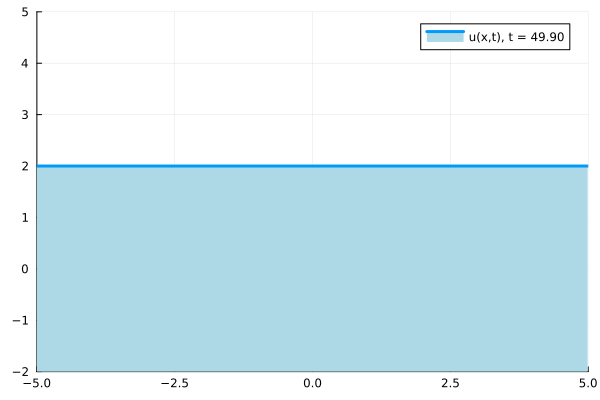

[ Info: Saved animation to /Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2023/notebooks/nonlinear_heat_4th.gif


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2023/notebooks/nonlinear_heat_4th.gif")
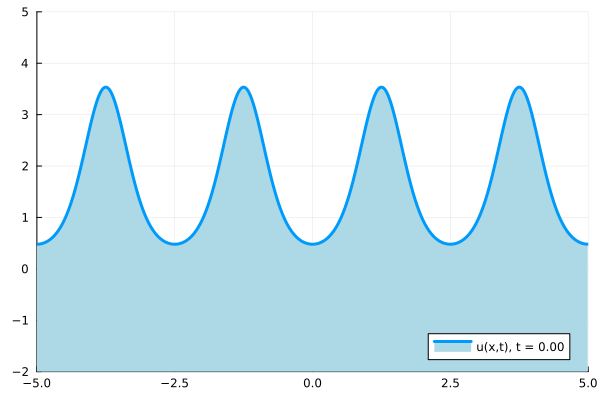

In [40]:
anim = Animation()
η = x -> 1.3*exp.(-cos.(4*pi*x/L))

L = 5.
N = 2^10
γ = 1.
X = mgrid(N,L)
c = mfft(η(X))
D2 = diffvec(L,N,2)
U = mifft(c)
cl = [-2,5]
k = 0.1
t = 0.0

N = u -> u.^2.0.*(1 .- u).*(u .- 2.0)
NF = c -> mfft(N(mifft(c)))

S0 = Diagonal(exp.(D2*k/2))
S1 = Diagonal(exp.(D2*k))


E0 = k*stable_eval(f0, D2*k, 2) |> Diagonal
E1 = k*stable_eval(f1, D2*k, 2) |> Diagonal
E2 = k*stable_eval(f2, D2*k, 2) |> Diagonal
E3 = k*stable_eval(f3, D2*k, 2) |> Diagonal

plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)



for i = 2:500
    t += k
    aa = S0*c + E0*NF(c)
    bb = S0*c + E0*NF(aa)
    cc = S0*aa + E0*(2*NF(bb)-NF(c))
    c = S1*c + E1*NF(c) + E2*(NF(aa) + NF(bb)) + E3*NF(cc)
    IJulia.clear_output(true)        
    plot(X, mifft(c) |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
    frame(anim)
end
gif(anim,"nonlinear_heat_4th.gif")